# Segmentation

In [1]:
import sys, os
sys.path.append('../')
import matplotlib.pyplot as plt 
import numpy as np

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Constants

In [2]:
SEED = 666
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_VALIDATION = 4

IMAGE_HEIGHT = 128
IMAGE_WIDTH =  128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

NUM_OF_EPOCHS = 100

NUM_TRAIN = 424
NUM_VALIDATION = 45

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_VALIDATION = NUM_VALIDATION // BATCH_SIZE_VALIDATION

data_dir_training = '../data/training'
data_dir_train_img = os.path.join(data_dir_training, 'img')
data_dir_train_mask = os.path.join(data_dir_training, 'mask')

data_dir_validation = '../data/validation'
data_dir_validation_img = os.path.join(data_dir_validation, 'img')
data_dir_validation_mask = os.path.join(data_dir_validation, 'mask')

data_dir_test = '../data/test'
data_dir_test_img = os.path.join(data_dir_test, 'img')
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

## Generators

In [3]:
def create_segmentation_generator_train(img_path, mask_path, BATCH_SIZE, IMG_SIZE, SEED):

    data_gen_args_img = dict(rescale=1./255,
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
                    rotation_range=5,
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
                     zoom_range=0.3,
                     horizontal_flip = True

    )

    data_gen_args_mask = dict(rescale=1./255,
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
                     rotation_range=5,
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
                     zoom_range=0.3,
                     horizontal_flip = True
    )



    img_data_gen = ImageDataGenerator(**data_gen_args_img)
    mask_data_gen = ImageDataGenerator(**data_gen_args_mask)

    img_generator = img_data_gen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    mask_generator = mask_data_gen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    return zip(img_generator, mask_generator)


    #! do not perform data augmentation in the test generator
def create_segmentation_generator_validation(img_path, mask_path, BATCH_SIZE, IMG_SIZE, SEED):

    data_gen_args = dict(rescale=1./255)

    img_data_gen = ImageDataGenerator(**data_gen_args)
    mask_data_gen = ImageDataGenerator(**data_gen_args)

    img_generator = img_data_gen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    mask_generator = mask_data_gen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    return zip(img_generator, mask_generator)

def create_segmentation_generator_test(img_path, mask_path, BATCH_SIZE, IMG_SIZE, SEED):

    data_gen_args = dict(rescale=1./255)

    img_data_gen = ImageDataGenerator(**data_gen_args)
    mask_data_gen = ImageDataGenerator(**data_gen_args)

    img_generator = img_data_gen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    mask_generator = mask_data_gen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    return zip(img_generator, mask_generator)

In [4]:
train_generator = create_segmentation_generator_train(data_dir_train_img, data_dir_train_mask, BATCH_SIZE_TRAIN, IMG_SIZE, SEED)

validation_generator = create_segmentation_generator_validation(data_dir_validation_img, data_dir_validation_mask, BATCH_SIZE_VALIDATION, IMG_SIZE, SEED)

Found 424 images belonging to 1 classes.
Found 424 images belonging to 1 classes.
Found 45 images belonging to 1 classes.
Found 45 images belonging to 1 classes.


In [5]:
def display(display_list):
    plt.figure(figsize=(12,8))
    title = ['Input image', 'True Mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [6]:
def show_dataset(datagen, num=1):
    for i in range(0, num):
        image, mask = next(datagen)
        display([image[0], mask[0]])


### Show trainig data

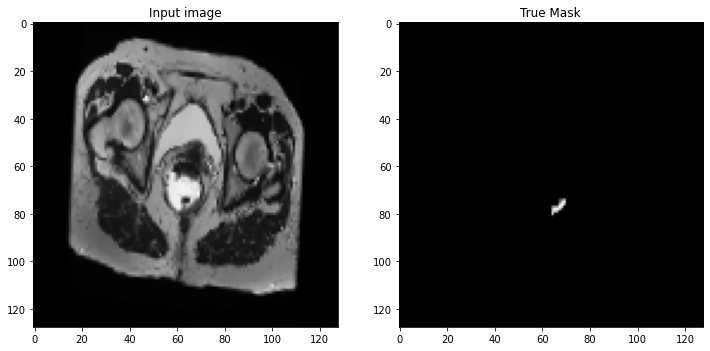

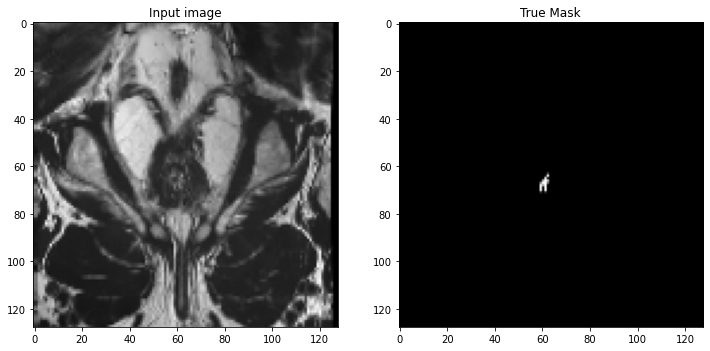

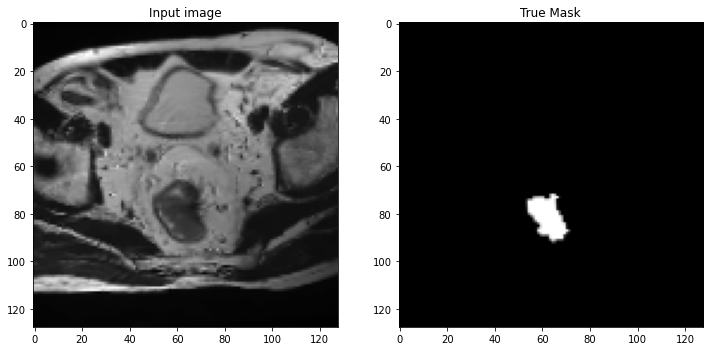

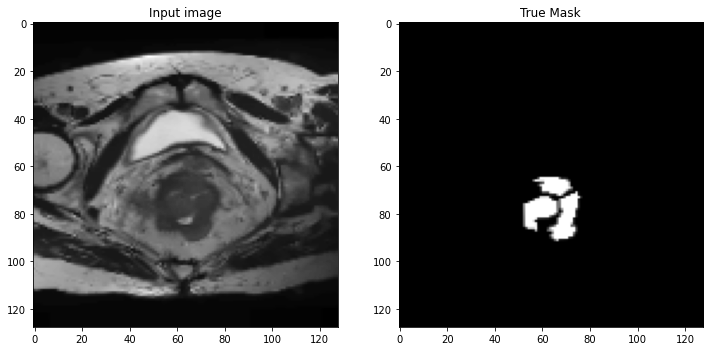

In [7]:
show_dataset(train_generator, 4) # training

### Show test data

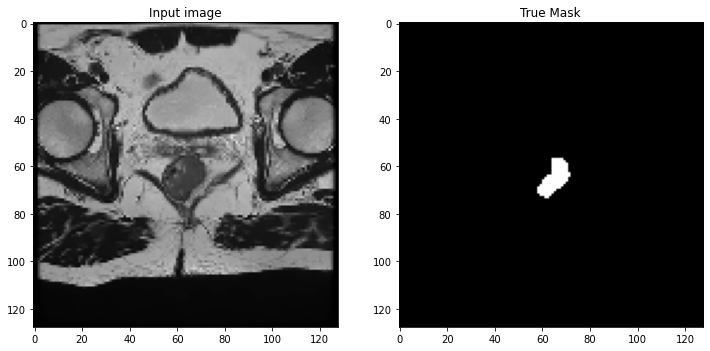

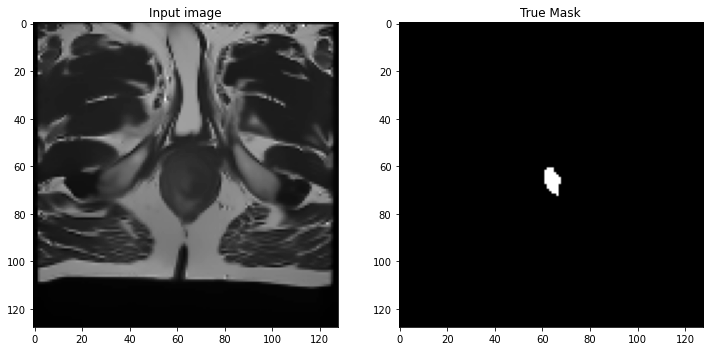

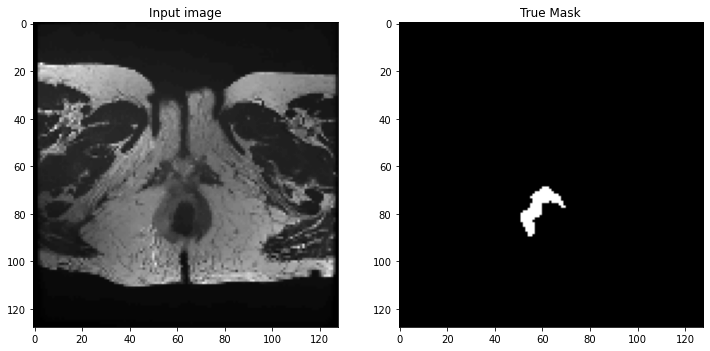

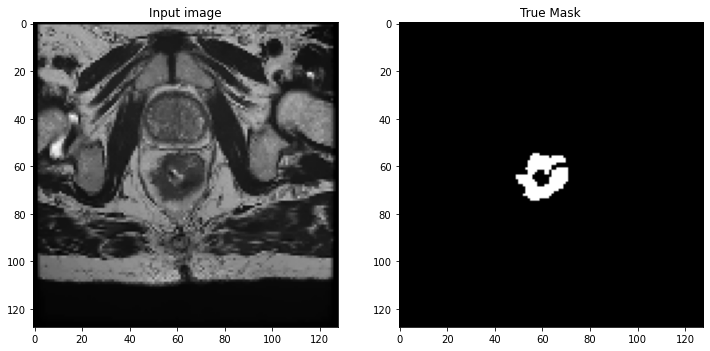

In [8]:
show_dataset(validation_generator, 4) # validation

## U-Net Model

In [9]:
def unet(n_levels=4, initial_features=64, n_conv=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_conv):
            x = tf.keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = tf.keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = tf.keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = tf.keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_conv):
            x = tf.keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = tf.keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return tf.keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [ ]:
from tf.keras import backend as K

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def mean_iou(y_true, y_pred):
    th = 0.5
    y_pred_ = tf.to_int32(y_pred > th)
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

In [14]:
model = unet()

metrics = [  tf.keras.metrics.MeanIoU(2)

           ]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

model.summary()

Model: "UNET-L4-F64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_31[0][0]                  
________________________________________________________________________________________

In [15]:
model_name = f'_{IMAGE_HEIGHT}_{IMAGE_WIDTH}'+'_'+'opt=adam'+'_'+'loss=bin_crossentropy'

In [16]:
callbacks = [

   tf.keras.callbacks.ModelCheckpoint('../data/models/checkpoints/' + model_name + '_checkpoint' + '.h5', save_best_only=True)
   #tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', mode='min')
]

history = model.fit(train_generator,
            steps_per_epoch=EPOCH_STEP_TRAIN, 
            validation_data=validation_generator, 
            validation_steps=EPOCH_STEP_VALIDATION,
            epochs=NUM_OF_EPOCHS,
            callbacks=callbacks)

Epoch 1/100
106/106 [==============================] - 84s 789ms/step - loss: 0.1566 - mean_io_u_1: 0.4963 - val_loss: 0.0573 - val_mean_io_u_1: 0.4928
Epoch 2/100
106/106 [==============================] - 85s 799ms/step - loss: 0.0455 - mean_io_u_1: 0.4966 - val_loss: 0.0553 - val_mean_io_u_1: 0.4929
Epoch 3/100
106/106 [==============================] - 85s 804ms/step - loss: 0.0411 - mean_io_u_1: 0.4964 - val_loss: 0.0725 - val_mean_io_u_1: 0.4924
Epoch 4/100
106/106 [==============================] - 84s 796ms/step - loss: 0.0399 - mean_io_u_1: 0.4966 - val_loss: 0.0519 - val_mean_io_u_1: 0.4935
Epoch 5/100
106/106 [==============================] - 84s 795ms/step - loss: 0.0337 - mean_io_u_1: 0.4962 - val_loss: 0.0421 - val_mean_io_u_1: 0.4927
Epoch 6/100
106/106 [==============================] - 85s 806ms/step - loss: 0.0287 - mean_io_u_1: 0.4966 - val_loss: 0.0364 - val_mean_io_u_1: 0.4930
Epoch 7/100
106/106 [==============================] - 84s 795ms/step - loss: 0.0305 - m

In [17]:
model.save('../data/models/' + model_name + '.h5')

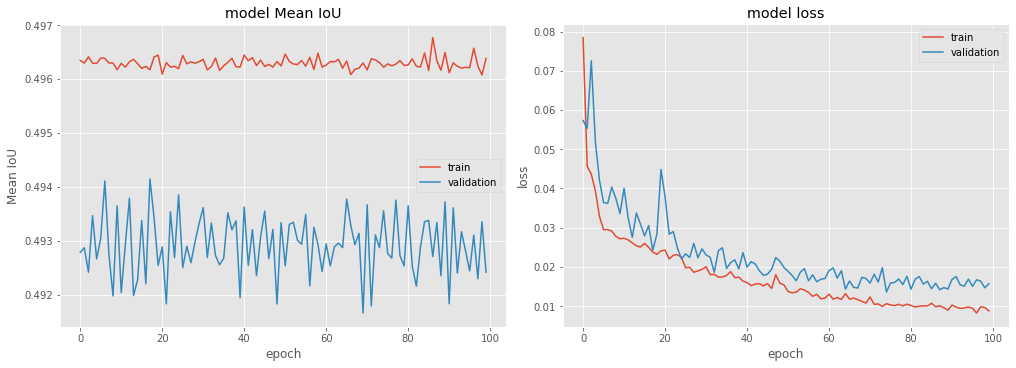

<Figure size 432x288 with 0 Axes>

In [18]:
plt.style.use('ggplot')


fig, ax = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
ax[0].plot(history.history['mean_io_u_1'])
ax[0].plot(history.history['val_mean_io_u_1'])
ax[0].set_title('model Mean IoU')
ax[0].set_ylabel('Mean IoU')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'validation'], loc='best')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'validation'], loc='best')



plt.show()


plt.savefig('../data/plots/' + model_name + '.png')

### Predictions

In [19]:
validation_generator = create_segmentation_generator_validation(data_dir_validation_img, data_dir_validation_mask, 1, IMG_SIZE, SEED)

Found 45 images belonging to 1 classes.
Found 45 images belonging to 1 classes.


In [20]:
def show_prediction(datagen, num=1):
    for i in range(0, num):
        image, mask = next(datagen)
        pred_mask = model.predict(image) 
        display([image[0], mask[0], pred_mask[0]])

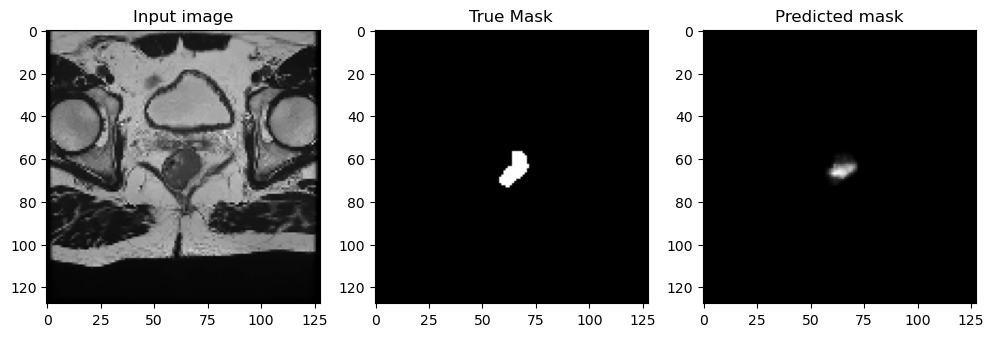

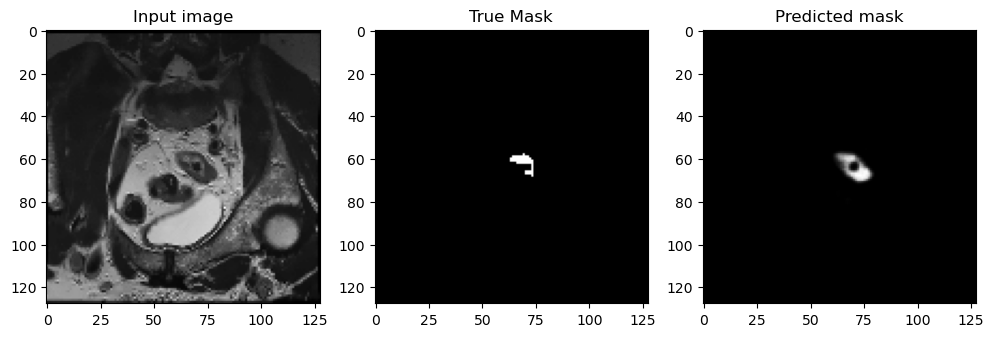

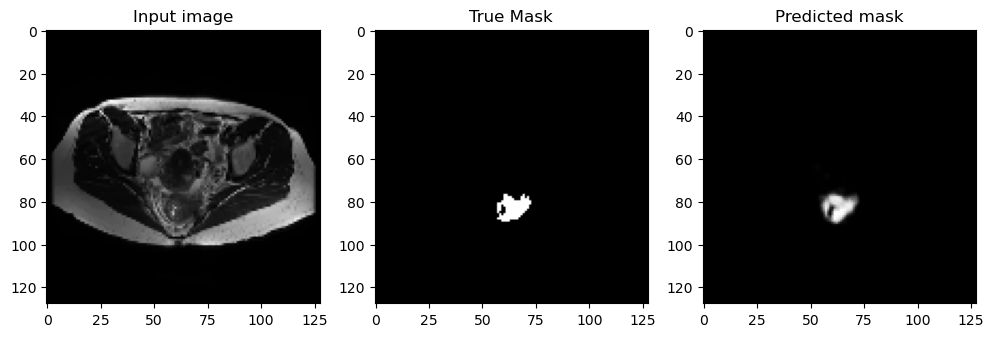

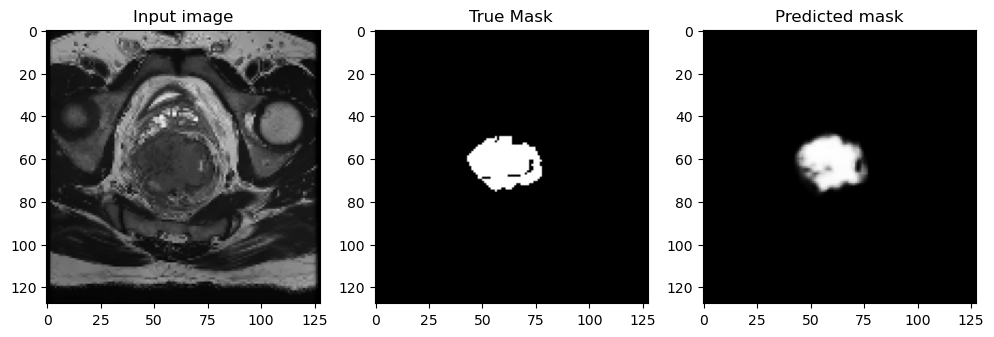

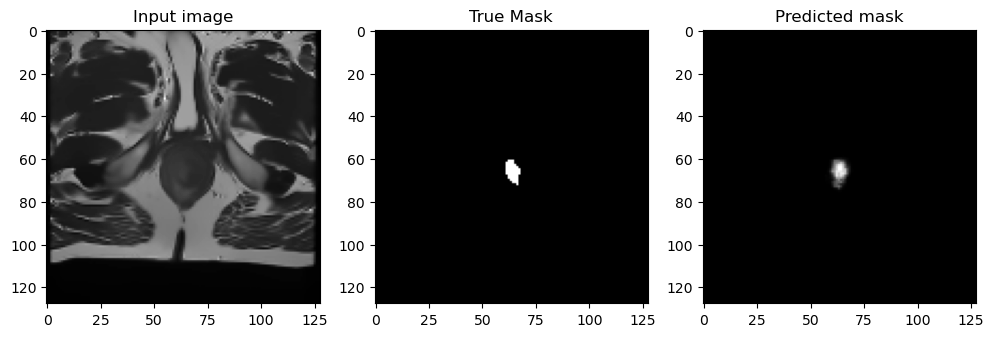

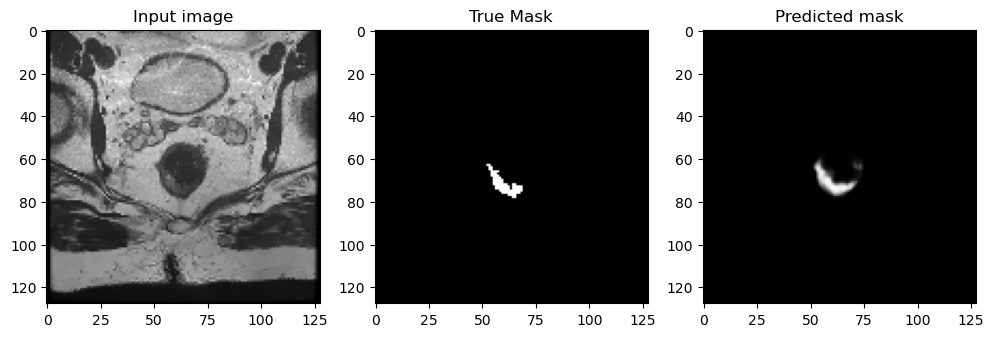

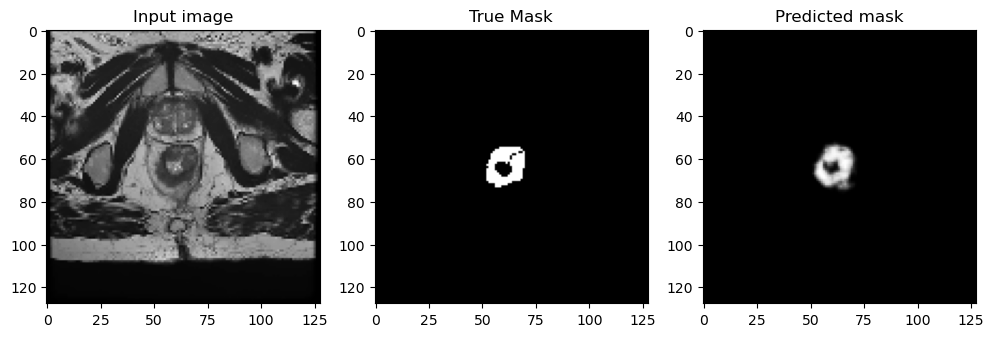

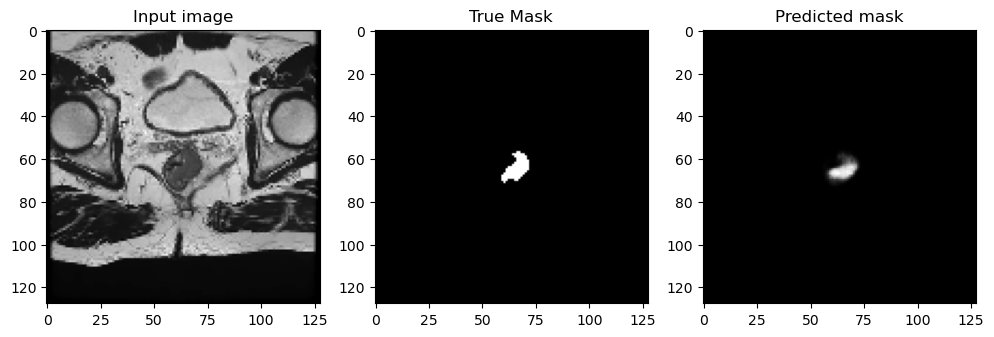

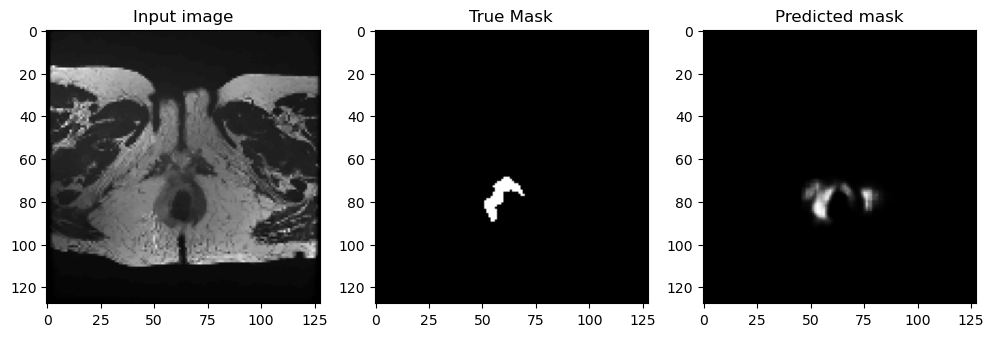

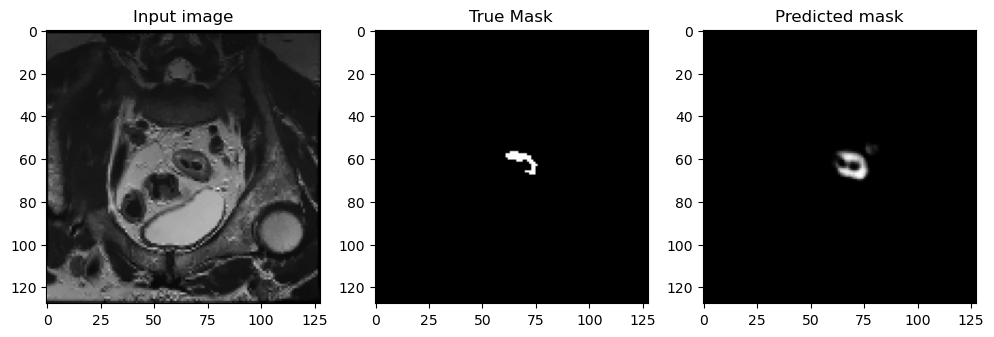

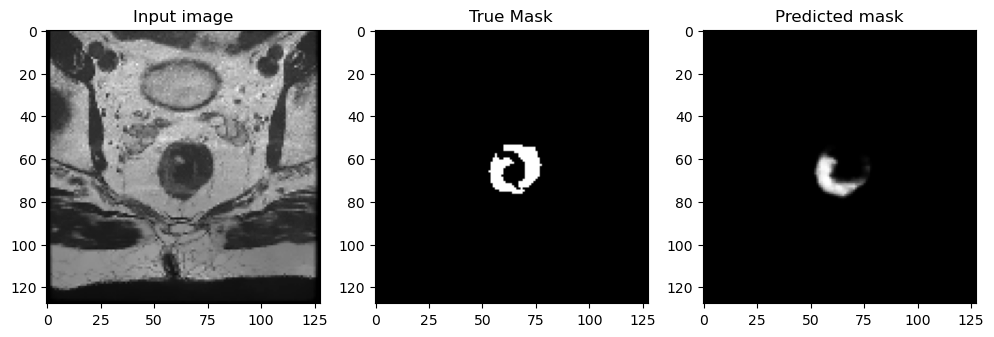

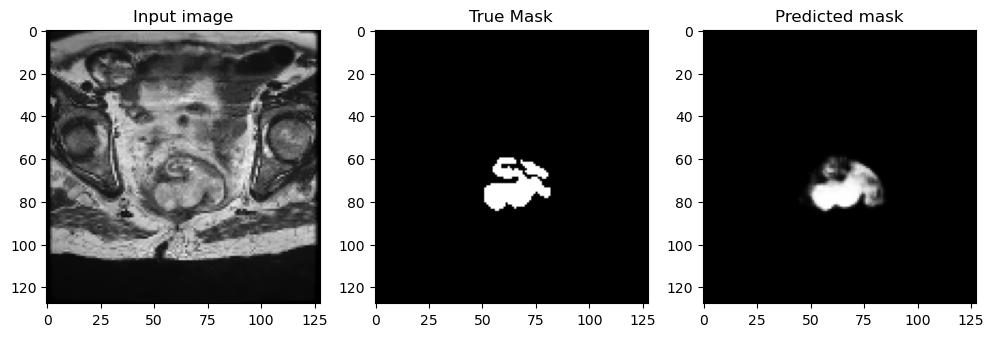

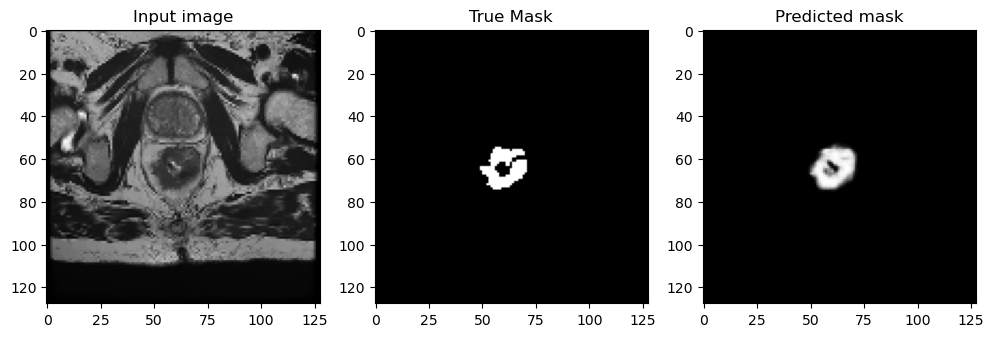

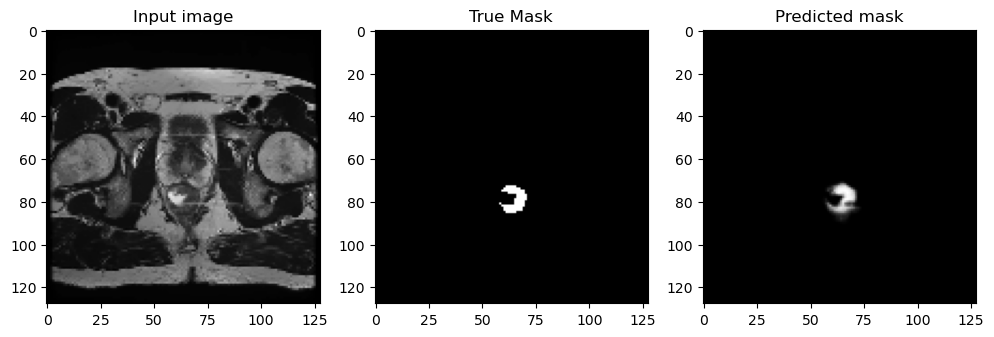

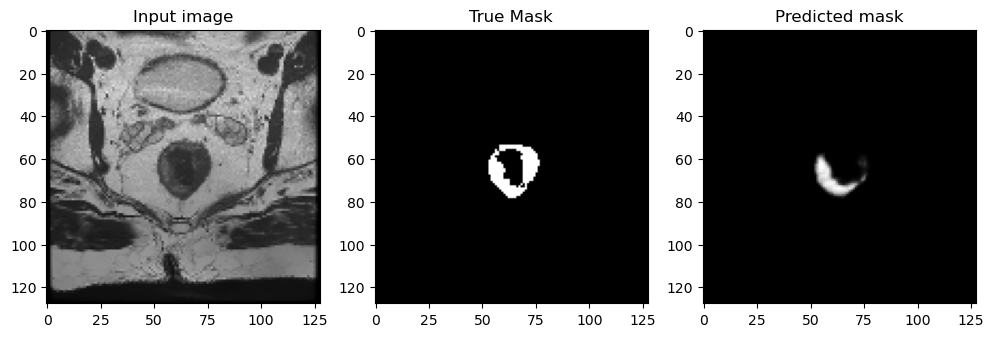

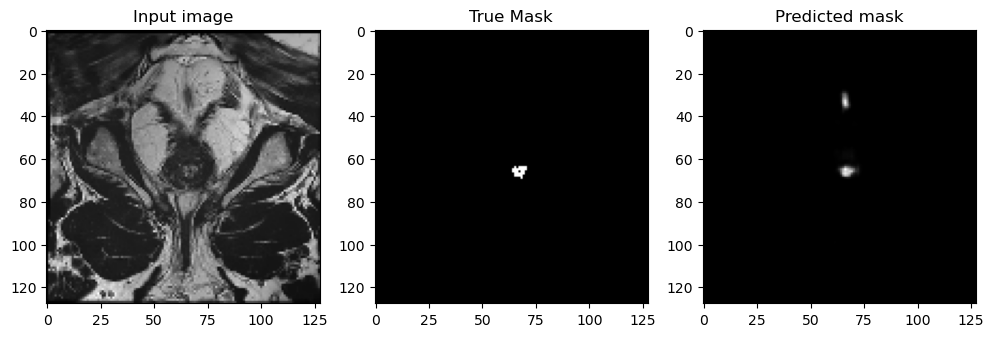

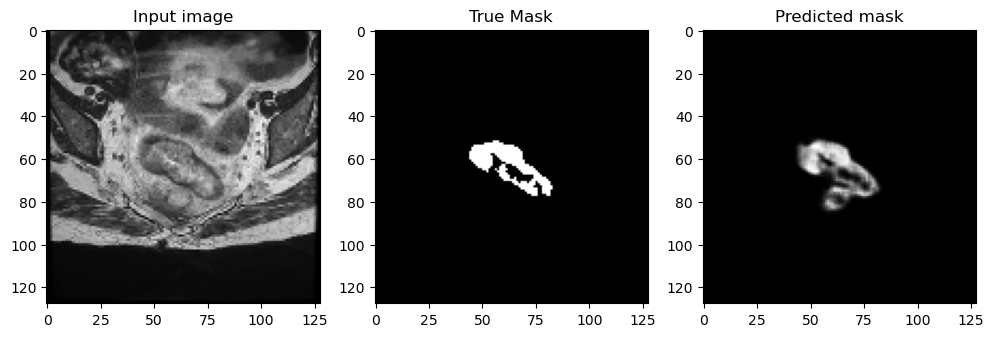

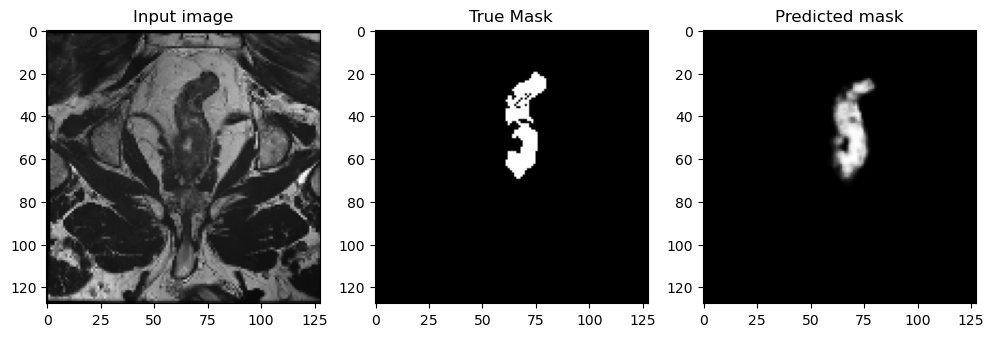

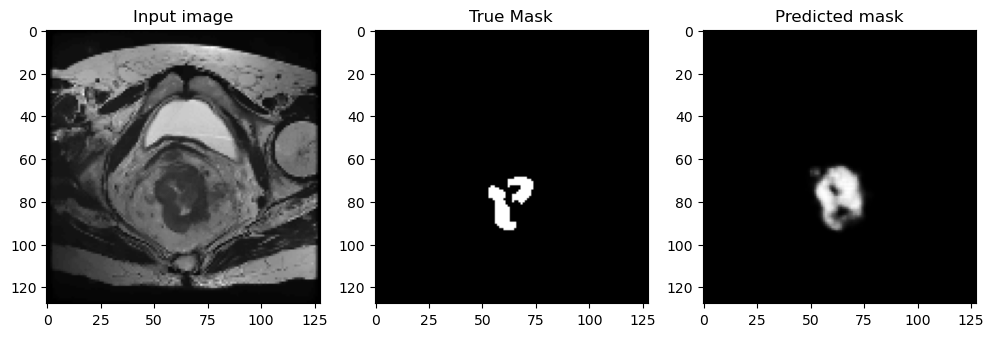

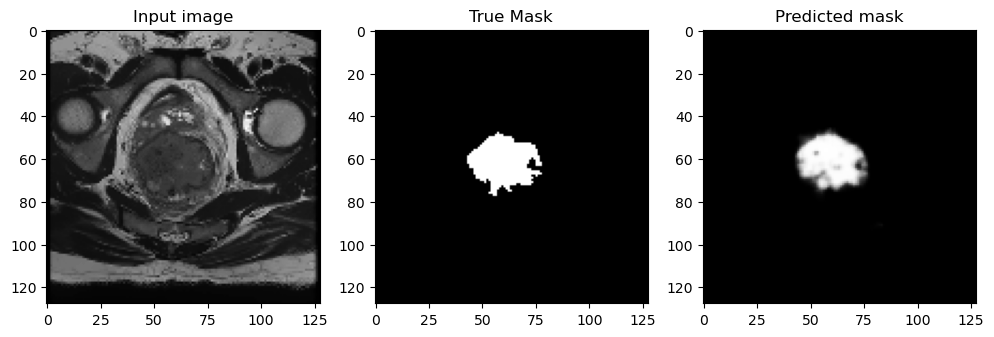

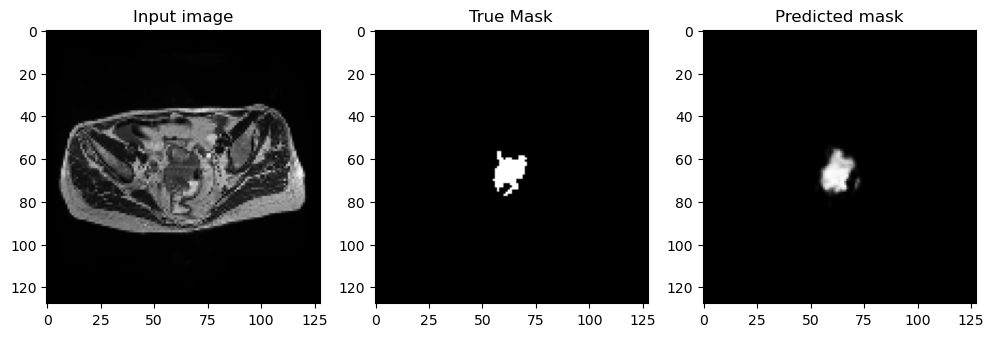

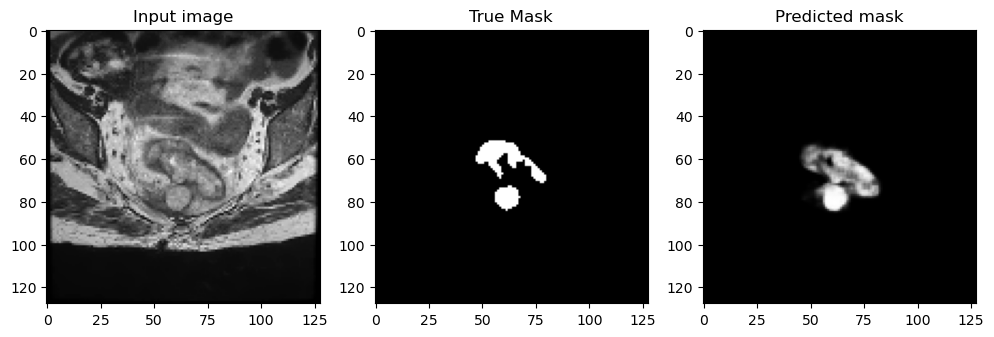

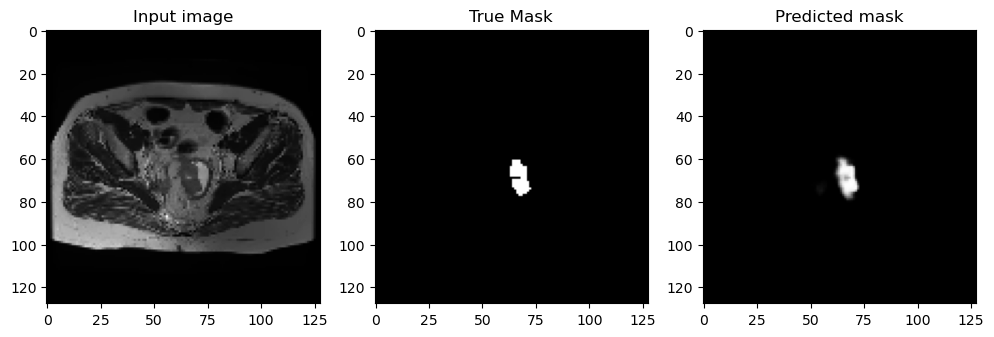

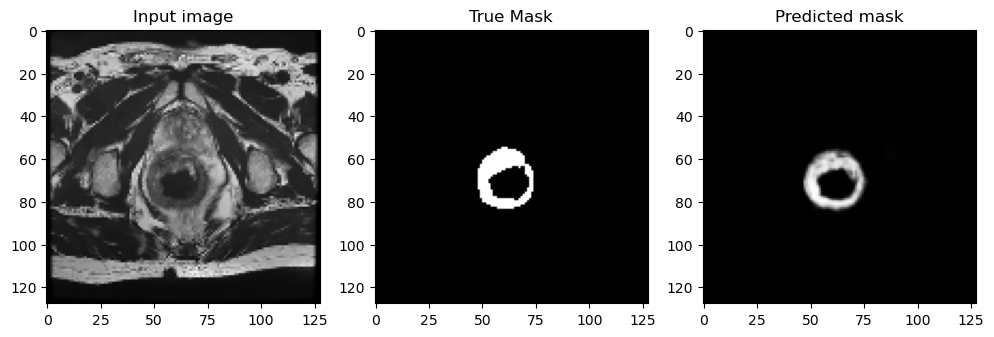

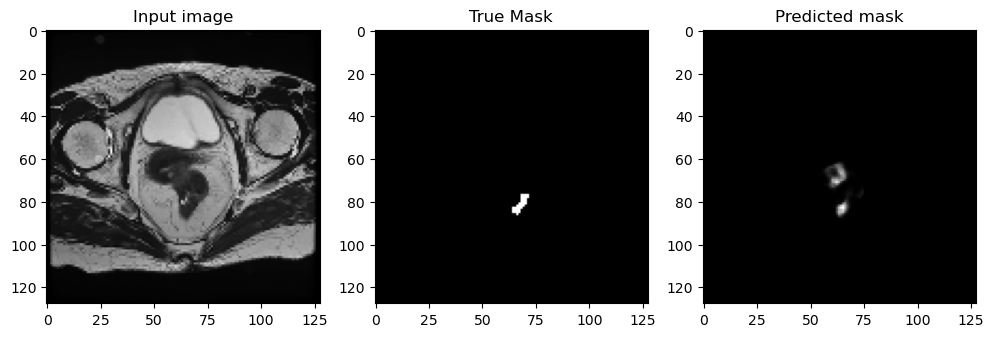

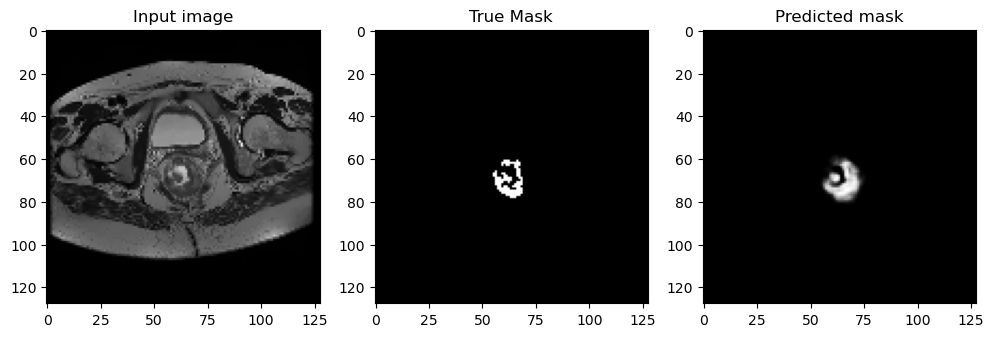

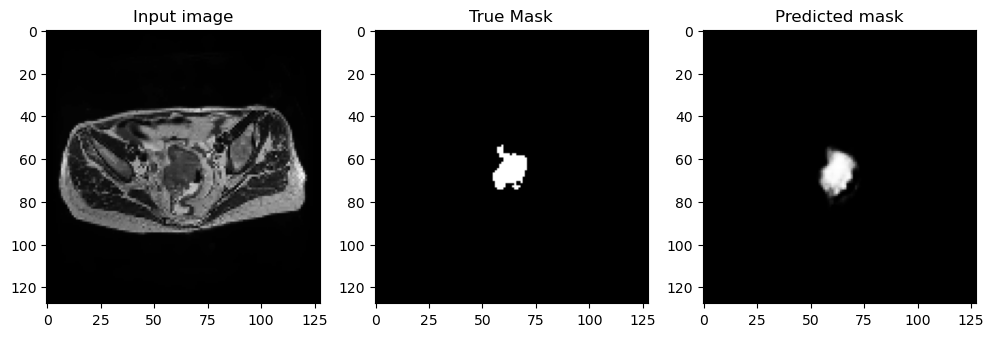

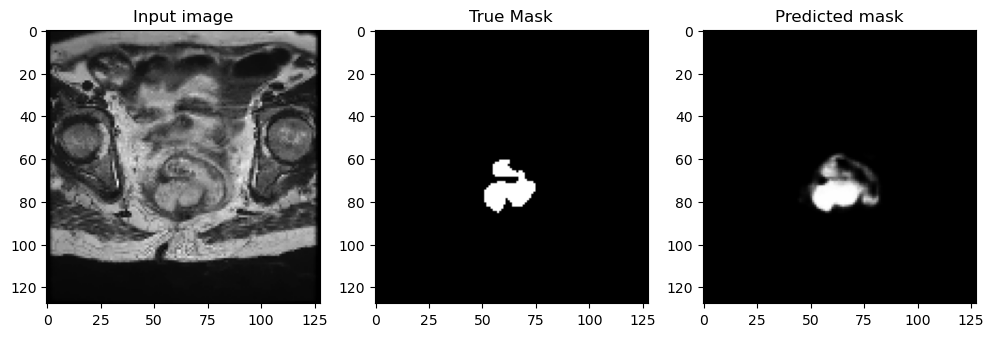

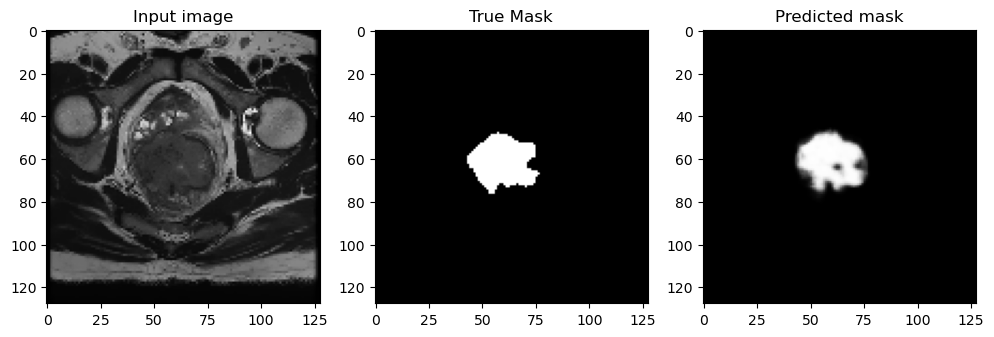

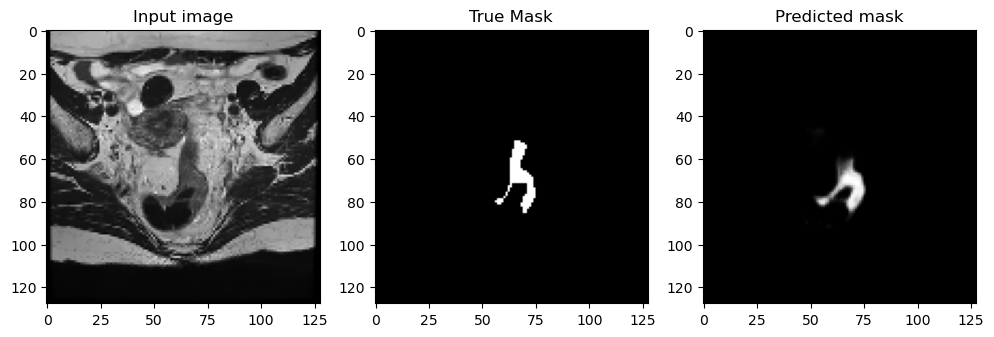

In [21]:
plt.style.use('default')

show_prediction(validation_generator, 30)

Found 17 images belonging to 1 classes.
Found 17 images belonging to 1 classes.


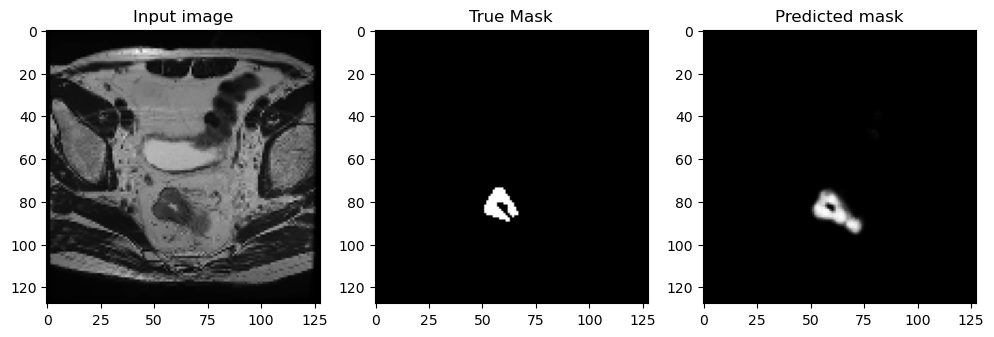

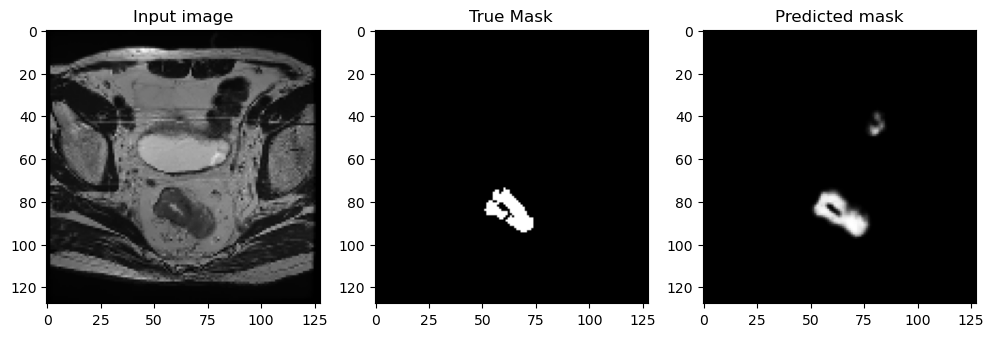

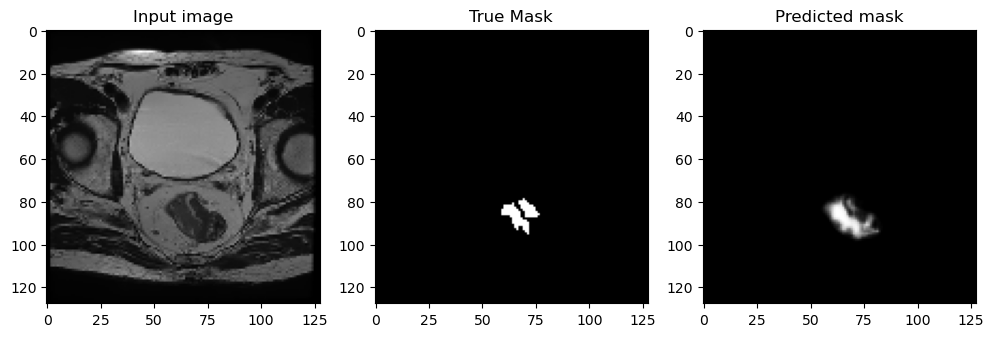

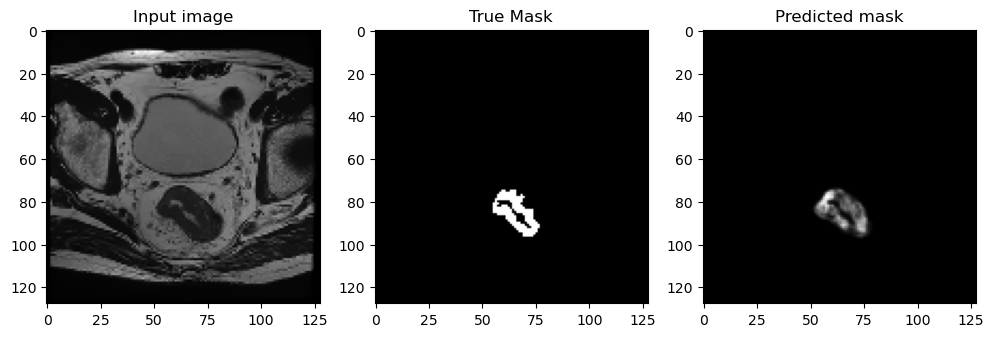

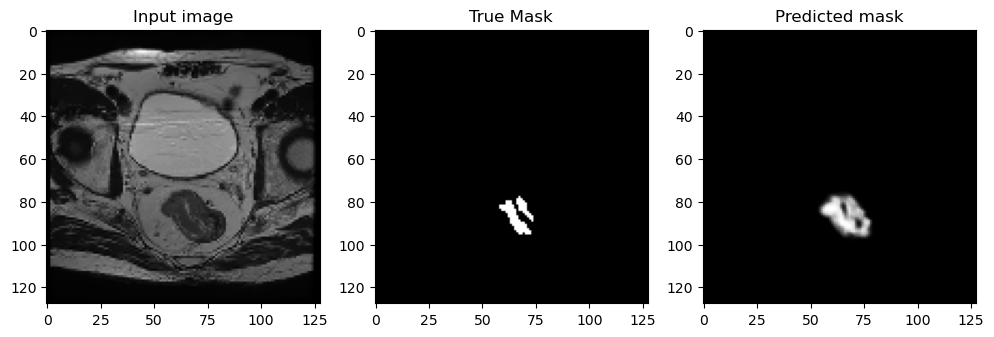

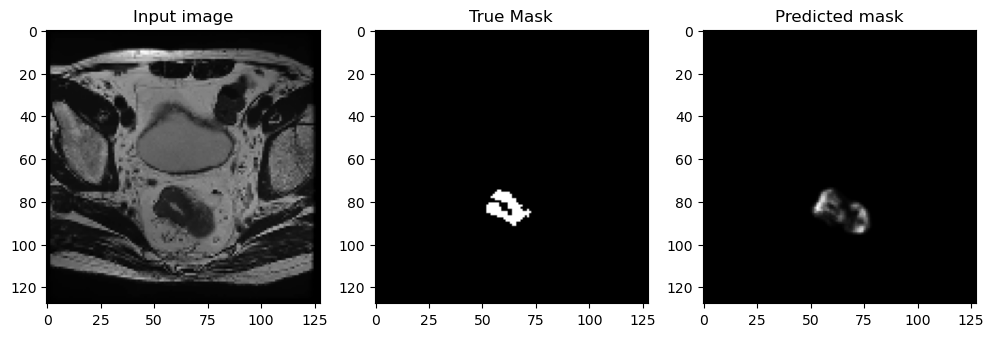

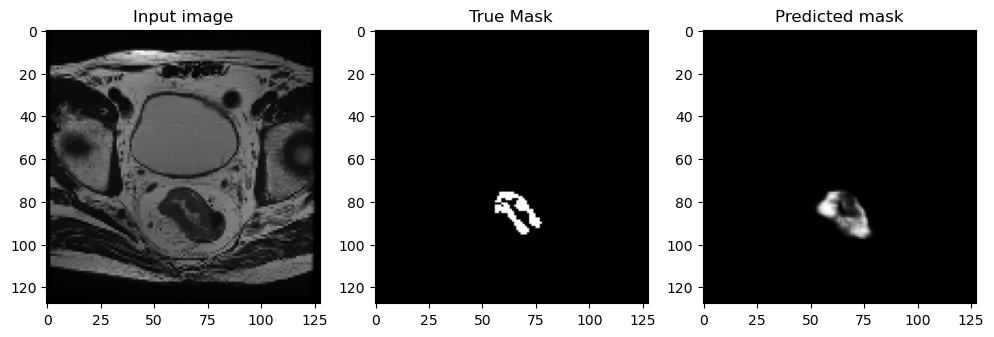

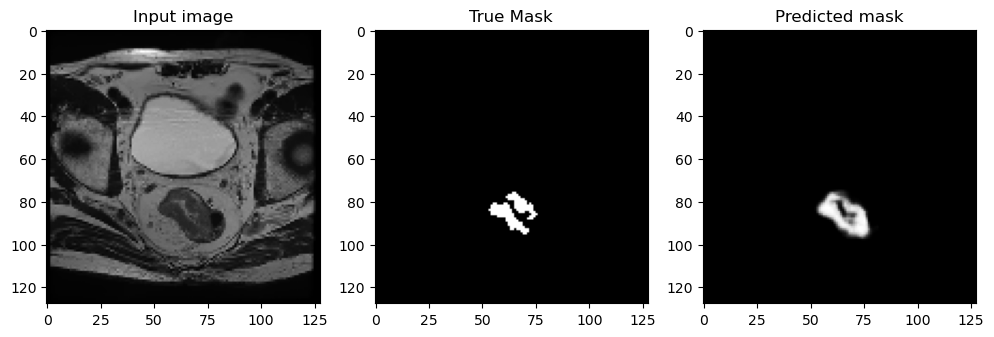

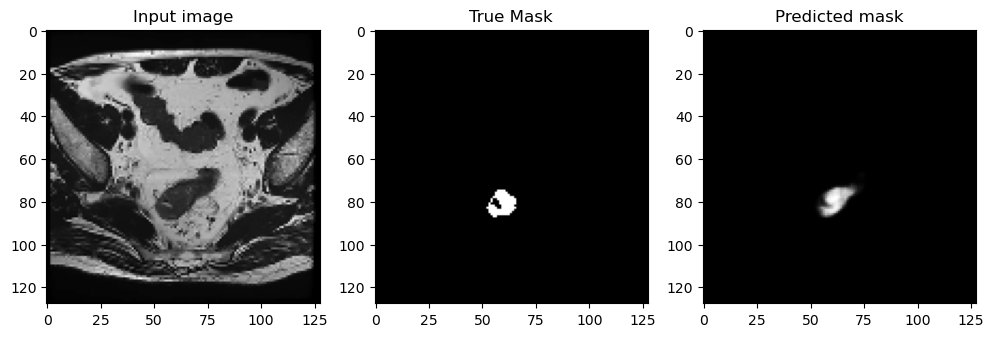

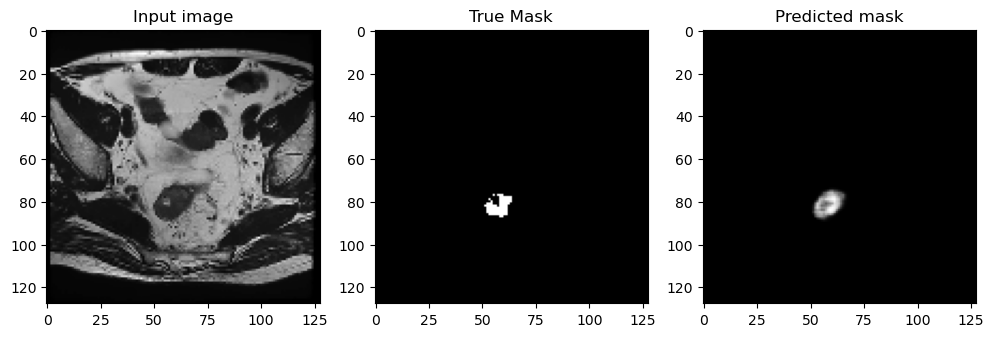

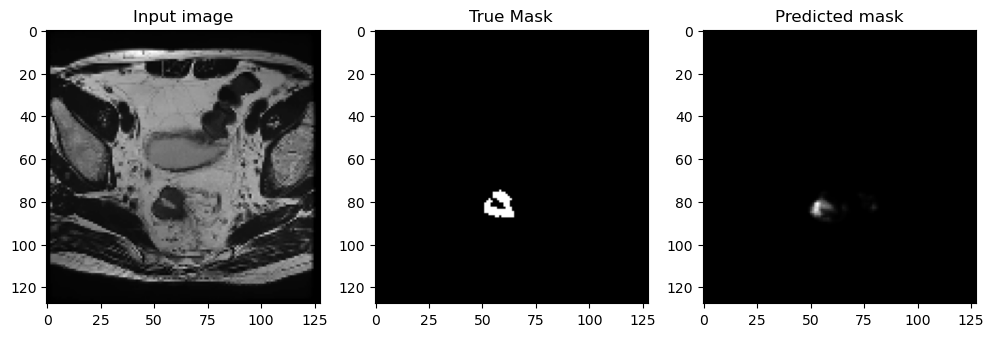

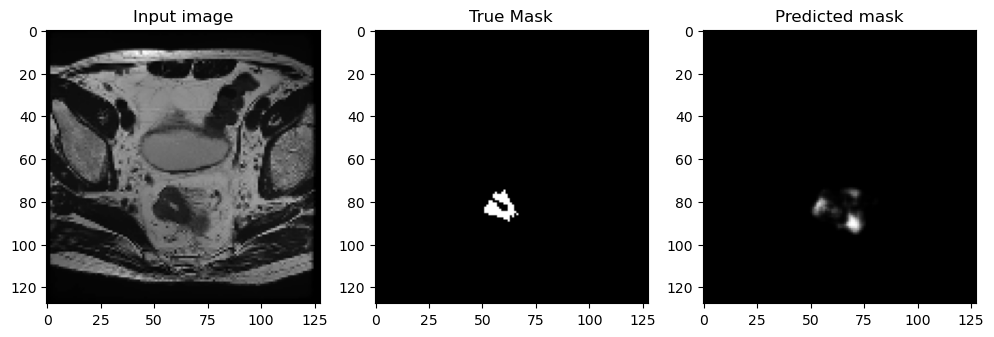

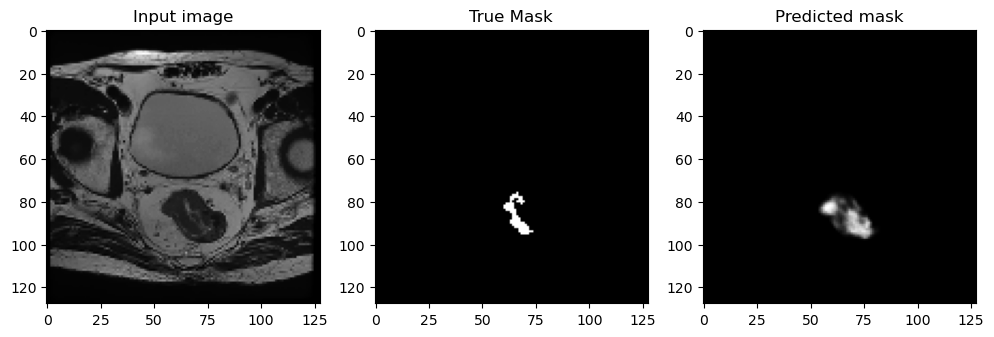

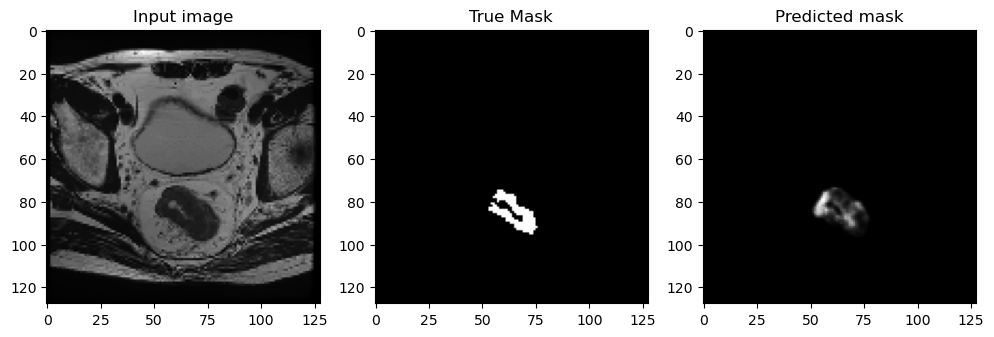

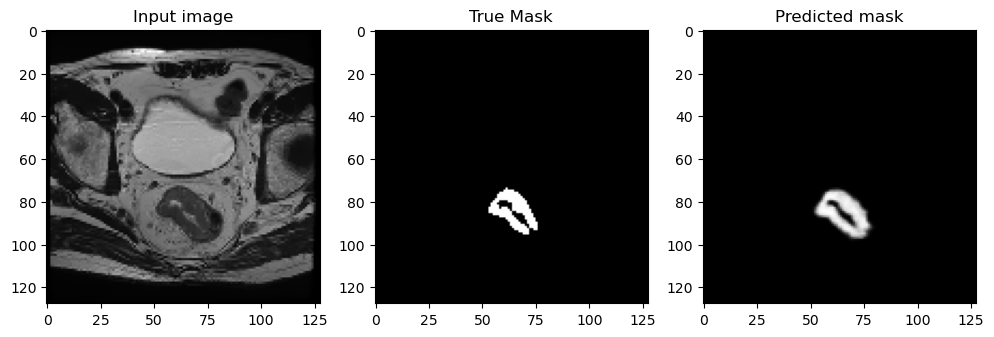

In [23]:

test_generator = create_segmentation_generator_validation(data_dir_test_img, data_dir_test_mask, 1, IMG_SIZE, SEED)

show_prediction(test_generator, 15)